In [ ]:

# Step 0 — Setup: installs, imports, seeds

!pip -q install kaggle timm scikit-learn tqdm

import os, sys, json, random, shutil, math, glob, time
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

import timm  # for ViT
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
Device: cuda


In [2]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
 
# Step 1 — Download dataset from Kaggle
# (Upload kaggle.json when prompted)
 
from google.colab import files
print("Upload kaggle.json (Kaggle API token).")
files.upload()


Upload kaggle.json (Kaggle API token).


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nusratjahanbeg207","key":"274395c89c98414cba604f569986d579"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download & unzip
!kaggle datasets download -d artyomkolas/3-kinds-of-pneumonia -p ./pneumonia_data
!unzip -q ./pneumonia_data/3-kinds-of-pneumonia.zip -d ./pneumonia_data

DATA_ROOT = Path("./pneumonia_data") / "Curated X-Ray Dataset"
assert DATA_ROOT.exists(), "Dataset root not found. Check unzip path!"

Dataset URL: https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 3.47G/3.49G [00:35<00:00, 219MB/s]
100% 3.49G/3.49G [00:35<00:00, 105MB/s]


In [ ]:
 
# Step 2 — Index images (paths + labels) into a DataFrame

 
# Expected subfolders (names may have spaces):
# 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19'
CLASS_NAMES = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Classes:", CLASS_NAMES)
label2idx = {c: i for i, c in enumerate(CLASS_NAMES)}
idx2label = {i: c for c, i in label2idx.items()}

rows = []
for cls in CLASS_NAMES:
    for img_path in (DATA_ROOT/cls).glob("*.*"):
        if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
            rows.append({"path": str(img_path), "label": cls, "y": label2idx[cls]})
df = pd.DataFrame(rows)
print("Total images:", len(df))
df.sample(5)


Classes: ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
Total images: 9208


,path,label,y
248,pneumonia_data/Curated X-Ray Dataset/COVID-19/...,COVID-19,0
2165,pneumonia_data/Curated X-Ray Dataset/Normal/No...,Normal,1
6847,pneumonia_data/Curated X-Ray Dataset/Pneumonia...,Pneumonia-Bacterial,2
4812,pneumonia_data/Curated X-Ray Dataset/Pneumonia...,Pneumonia-Bacterial,2
2157,pneumonia_data/Curated X-Ray Dataset/Normal/No...,Normal,1


In [ ]:
 
# Step 3 — Create two disjoint "domains" A and B (for cross-dataset validation)
#          Stratified split by label; keep classes balanced across A/B.

 
MAX_SAMPLES_PER_CLASS = None  # e.g., 500 to limit CPU time, or None for all

def stratified_cap(df, max_per_class=None):
    if max_per_class is None:
        return df.copy()
    parts = []
    for cls, g in df.groupby("label"):
        parts.append(g.sample(n=min(max_per_class, len(g)), random_state=SEED))
    return pd.concat(parts).reset_index(drop=True)

df_limited = stratified_cap(df, MAX_SAMPLES_PER_CLASS)

# 60/40 split -> A (train domain), B (external domain)
train_A, test_B = train_test_split(
    df_limited, test_size=0.4, stratify=df_limited["y"], random_state=SEED
)
train_B, test_A = train_test_split(
    df_limited, test_size=0.6, stratify=df_limited["y"], random_state=SEED
)  # for symmetry if needed; but we'll derive A/B from the first split

# To be explicit:
A_df = train_A.reset_index(drop=True)     # Domain A
B_df = test_B.reset_index(drop=True)      # Domain B (disjoint from A)

print("Domain A size:", len(A_df), "Domain B size:", len(B_df))
print("A label counts:\n", A_df['label'].value_counts())
print("B label counts:\n", B_df['label'].value_counts())


Domain A size: 5524 Domain B size: 3684
A label counts:
 label
Normal                 1962
Pneumonia-Bacterial    1800
Pneumonia-Viral         993
COVID-19                769
Name: count, dtype: int64
B label counts:
 label
Normal                 1308
Pneumonia-Bacterial    1201
Pneumonia-Viral         663
COVID-19                512
Name: count, dtype: int64


In [ ]:
 
# Step 4 — Datasets & DataLoaders (with augmentation)
#          ViT & ResNet expect 3-channel 224x224, ImageNet normalization.
 
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

class XRayDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")  # robust to grayscale
        x = self.transform(img)
        y = int(row["y"])
        return x, y, row["path"]

def make_loader(df, transform, batch_size=16, shuffle=False):
    ds = XRayDataset(df, transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=False)

# Example loaders for quick tests (real training uses CV below)
tmp_train_loader = make_loader(A_df, train_tfms, shuffle=True)
tmp_val_loader   = make_loader(B_df, eval_tfms, shuffle=False)


In [ ]:
 
# Step 5 — Models: CNN (ResNet18), ViT (timm), and Hybrid (concat features)

 
def build_resnet18_backbone():
    cnn = models.resnet18(pretrained=True)
    for p in cnn.parameters(): p.requires_grad = False
    cnn.fc = nn.Identity()  # output = 512-dim
    return cnn, 512

def build_vit_backbone():
    vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, global_pool='avg')
    for p in vit.parameters(): p.requires_grad = False
    # output = 768-dim
    return vit, 768

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn, cnn_dim = build_resnet18_backbone()
        self.vit, vit_dim = build_vit_backbone()
        self.classifier = nn.Sequential(
            nn.Linear(cnn_dim + vit_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        f_cnn = self.cnn(x)         # [B, 512]
        f_vit = self.vit(x)         # [B, 768]
        feats = torch.cat([f_cnn, f_vit], dim=1)
        logits = self.classifier(feats)
        return logits

class CNNOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn, d = build_resnet18_backbone()
        self.classifier = nn.Linear(d, num_classes)
    def forward(self, x):
        return self.classifier(self.cnn(x))

class ViTOnly(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vit, d = build_vit_backbone()
        self.classifier = nn.Linear(d, num_classes)
    def forward(self, x):
        return self.classifier(self.vit(x))


In [ ]:
 
# Step 6 — Training & Evaluation utilities
#          Metrics: Acc, Precision/Recall/F1 (macro), AUC (macro & micro)
 
def get_optimizer(model, lr=1e-4, weight_decay=0.0):
    # Train only classifier params (frozen backbones)
    params = [p for p in model.parameters() if p.requires_grad]
    return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    all_y, all_pred, all_prob = [], [], []

    for x, y, _ in loader:
        x, y = x.to(DEVICE), torch.tensor(y).to(DEVICE)
        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            if is_train:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        preds = probs.argmax(axis=1)
        all_y.extend(y.cpu().numpy().tolist())
        all_pred.extend(preds.tolist())
        all_prob.append(probs)

    all_prob = np.concatenate(all_prob, axis=0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, np.array(all_y), np.array(all_pred), all_prob

def compute_metrics(y_true, y_pred, prob, num_classes):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    # Multi-class AUC (one-vs-rest)
    try:
        auc_macro = roc_auc_score(y_true, prob, multi_class='ovr', average='macro')
        auc_micro = roc_auc_score(y_true, prob, multi_class='ovr', average='micro')
    except Exception:
        auc_macro, auc_micro = np.nan, np.nan
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc_macro": auc_macro, "auc_micro": auc_micro}

def print_metrics(title, metrics):
    print(f"{title} | "
          f"Acc: {metrics['acc']:.4f} | P: {metrics['prec']:.4f} | "
          f"R: {metrics['rec']:.4f} | F1: {metrics['f1']:.4f} | "
          f"AUC(macro): {metrics['auc_macro']:.4f} | AUC(micro): {metrics['auc_micro']:.4f}")

def plot_confusion(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label', xlabel='Predicted label', title=title
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, prob, class_names, title="ROC Curves"):
    # One-vs-rest ROC for each class
    y_true_bin = np.zeros((len(y_true), len(class_names)))
    for i, c in enumerate(y_true):
        y_true_bin[i, c] = 1
    fig = plt.figure(figsize=(6,5))
    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], prob[:, i])
        plt.plot(fpr, tpr, label=f"{cls} (AUC={auc(fpr, tpr):.3f})")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend()
    plt.show()


In [ ]:
 
# Step 7 — 5-fold CV inside Domain A (train/val) using Hybrid model
#          (kept light with small EPOCHS_CV)
 
BATCH_SIZE = 16
EPOCHS_CV = 4  # keep small for CPU; increase later if you can
NUM_CLASSES = len(CLASS_NAMES)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold_metrics = []

X = np.arange(len(A_df))
y = A_df['y'].values

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold}/5 =====")
    tr_df = A_df.iloc[tr_idx].reset_index(drop=True)
    va_df = A_df.iloc[va_idx].reset_index(drop=True)

    train_loader = make_loader(tr_df, train_tfms, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = make_loader(va_df, eval_tfms, batch_size=BATCH_SIZE, shuffle=False)

    model = HybridModel(num_classes=NUM_CLASSES).to(DEVICE)
    optim = get_optimizer(model, lr=1e-4)

    best_val = -1
    for ep in range(1, EPOCHS_CV+1):
        tr_loss, tr_y, tr_pred, tr_prob = run_epoch(model, train_loader, optimizer=optim)
        va_loss, va_y, va_pred, va_prob = run_epoch(model, val_loader, optimizer=None)

        tr_m = compute_metrics(tr_y, tr_pred, tr_prob, NUM_CLASSES)
        va_m = compute_metrics(va_y, va_pred, va_prob, NUM_CLASSES)
        print(f"Epoch {ep}: train loss {tr_loss:.4f} | val loss {va_loss:.4f}")
        print_metrics("  Train", tr_m); print_metrics("  Val  ", va_m)

        score = va_m['f1']
        if score > best_val:
            best_val = score
            torch.save(model.state_dict(), f"cv_fold{fold}_best.pth")

    # record final fold val metrics (last epoch)
    fold_metrics.append(va_m)

print("\n=== CV Results (A-domain) averaged over folds ===")
avg = {k: float(np.nanmean([m[k] for m in fold_metrics])) for k in fold_metrics[0].keys()}
print_metrics("CV(A)", avg)



===== Fold 1/5 =====


Epoch 1: train loss 0.7899 | val loss 0.5367
  Train | Acc: 0.7013 | P: 0.7012 | R: 0.6392 | F1: 0.6388 | AUC(macro): 0.8792 | AUC(micro): 0.9025
  Val   | Acc: 0.7964 | P: 0.8114 | R: 0.7419 | F1: 0.7592 | AUC(macro): 0.9401 | AUC(micro): 0.9531
Epoch 2: train loss 0.5682 | val loss 0.4516
  Train | Acc: 0.7816 | P: 0.7731 | R: 0.7518 | F1: 0.7535 | AUC(macro): 0.9226 | AUC(micro): 0.9460
  Val   | Acc: 0.8271 | P: 0.8272 | R: 0.7937 | F1: 0.8040 | AUC(macro): 0.9467 | AUC(micro): 0.9648
Epoch 3: train loss 0.5163 | val loss 0.4685
  Train | Acc: 0.7963 | P: 0.7827 | R: 0.7695 | F1: 0.7705 | AUC(macro): 0.9335 | AUC(micro): 0.9541
  Val   | Acc: 0.8118 | P: 0.8255 | R: 0.7665 | F1: 0.7789 | AUC(macro): 0.9470 | AUC(micro): 0.9608
Epoch 4: train loss 0.4912 | val loss 0.4745
  Train | Acc: 0.8018 | P: 0.7915 | R: 0.7784 | F1: 0.7805 | AUC(macro): 0.9374 | AUC(micro): 0.9575
  Val   | Acc: 0.8190 | P: 0.8399 | R: 0.7819 | F1: 0.7858 | AUC(macro): 0.9505 | AUC(micro): 0.9606

===== Fold 

Epoch 1: train loss 0.7972 | val loss 0.5618
  Train | Acc: 0.7015 | P: 0.7112 | R: 0.6407 | F1: 0.6456 | AUC(macro): 0.8764 | AUC(micro): 0.9014
  Val   | Acc: 0.7828 | P: 0.8087 | R: 0.7193 | F1: 0.7211 | AUC(macro): 0.9310 | AUC(micro): 0.9461
Epoch 2: train loss 0.5571 | val loss 0.5145
  Train | Acc: 0.7875 | P: 0.7777 | R: 0.7577 | F1: 0.7599 | AUC(macro): 0.9253 | AUC(micro): 0.9483
  Val   | Acc: 0.8000 | P: 0.8121 | R: 0.7534 | F1: 0.7534 | AUC(macro): 0.9408 | AUC(micro): 0.9543
Epoch 3: train loss 0.5078 | val loss 0.4753
  Train | Acc: 0.8029 | P: 0.7909 | R: 0.7759 | F1: 0.7774 | AUC(macro): 0.9328 | AUC(micro): 0.9554
  Val   | Acc: 0.8154 | P: 0.8157 | R: 0.7801 | F1: 0.7930 | AUC(macro): 0.9413 | AUC(micro): 0.9595
Epoch 4: train loss 0.4908 | val loss 0.4784
  Train | Acc: 0.8058 | P: 0.7956 | R: 0.7816 | F1: 0.7839 | AUC(macro): 0.9346 | AUC(micro): 0.9575
  Val   | Acc: 0.8000 | P: 0.8132 | R: 0.7515 | F1: 0.7393 | AUC(macro): 0.9449 | AUC(micro): 0.9608

===== Fold 

Epoch 1: train loss 0.8126 | val loss 0.5265
  Train | Acc: 0.6891 | P: 0.6932 | R: 0.6275 | F1: 0.6289 | AUC(macro): 0.8738 | AUC(micro): 0.8971
  Val   | Acc: 0.8063 | P: 0.7994 | R: 0.7725 | F1: 0.7804 | AUC(macro): 0.9394 | AUC(micro): 0.9579
Epoch 2: train loss 0.5726 | val loss 0.4762
  Train | Acc: 0.7846 | P: 0.7774 | R: 0.7580 | F1: 0.7611 | AUC(macro): 0.9225 | AUC(micro): 0.9451
  Val   | Acc: 0.8199 | P: 0.8220 | R: 0.7795 | F1: 0.7878 | AUC(macro): 0.9429 | AUC(micro): 0.9606
Epoch 3: train loss 0.5304 | val loss 0.4987
  Train | Acc: 0.7972 | P: 0.7884 | R: 0.7729 | F1: 0.7756 | AUC(macro): 0.9287 | AUC(micro): 0.9511
  Val   | Acc: 0.7937 | P: 0.7982 | R: 0.7914 | F1: 0.7891 | AUC(macro): 0.9442 | AUC(micro): 0.9558
Epoch 4: train loss 0.4926 | val loss 0.4589
  Train | Acc: 0.8024 | P: 0.7919 | R: 0.7789 | F1: 0.7808 | AUC(macro): 0.9372 | AUC(micro): 0.9574
  Val   | Acc: 0.8244 | P: 0.8315 | R: 0.7849 | F1: 0.7915 | AUC(macro): 0.9460 | AUC(micro): 0.9625

===== Fold 

Epoch 1: train loss 0.8090 | val loss 0.5658
  Train | Acc: 0.6945 | P: 0.6931 | R: 0.6327 | F1: 0.6355 | AUC(macro): 0.8728 | AUC(micro): 0.8972
  Val   | Acc: 0.7864 | P: 0.7810 | R: 0.7448 | F1: 0.7549 | AUC(macro): 0.9328 | AUC(micro): 0.9476
Epoch 2: train loss 0.5699 | val loss 0.4999
  Train | Acc: 0.7823 | P: 0.7688 | R: 0.7530 | F1: 0.7537 | AUC(macro): 0.9240 | AUC(micro): 0.9457
  Val   | Acc: 0.7928 | P: 0.7962 | R: 0.7366 | F1: 0.7332 | AUC(macro): 0.9406 | AUC(micro): 0.9567
Epoch 3: train loss 0.5115 | val loss 0.4583
  Train | Acc: 0.7993 | P: 0.7906 | R: 0.7730 | F1: 0.7759 | AUC(macro): 0.9335 | AUC(micro): 0.9548
  Val   | Acc: 0.8063 | P: 0.8007 | R: 0.7666 | F1: 0.7695 | AUC(macro): 0.9447 | AUC(micro): 0.9629
Epoch 4: train loss 0.4946 | val loss 0.4351
  Train | Acc: 0.8110 | P: 0.8024 | R: 0.7876 | F1: 0.7900 | AUC(macro): 0.9364 | AUC(micro): 0.9572
  Val   | Acc: 0.8253 | P: 0.8133 | R: 0.8026 | F1: 0.8053 | AUC(macro): 0.9465 | AUC(micro): 0.9659

===== Fold 

Epoch 1: train loss 0.8111 | val loss 0.7323
  Train | Acc: 0.6873 | P: 0.6898 | R: 0.6326 | F1: 0.6380 | AUC(macro): 0.8725 | AUC(micro): 0.8959
  Val   | Acc: 0.7002 | P: 0.7582 | R: 0.6495 | F1: 0.6445 | AUC(macro): 0.9264 | AUC(micro): 0.9110
Epoch 2: train loss 0.5719 | val loss 0.4845
  Train | Acc: 0.7719 | P: 0.7568 | R: 0.7406 | F1: 0.7417 | AUC(macro): 0.9223 | AUC(micro): 0.9451
  Val   | Acc: 0.8207 | P: 0.8269 | R: 0.7901 | F1: 0.8028 | AUC(macro): 0.9402 | AUC(micro): 0.9585
Epoch 3: train loss 0.5112 | val loss 0.5005
  Train | Acc: 0.7937 | P: 0.7774 | R: 0.7672 | F1: 0.7676 | AUC(macro): 0.9318 | AUC(micro): 0.9545
  Val   | Acc: 0.8034 | P: 0.8265 | R: 0.7527 | F1: 0.7653 | AUC(macro): 0.9415 | AUC(micro): 0.9557
Epoch 4: train loss 0.4921 | val loss 0.4490
  Train | Acc: 0.8014 | P: 0.7880 | R: 0.7745 | F1: 0.7753 | AUC(macro): 0.9375 | AUC(micro): 0.9576
  Val   | Acc: 0.8315 | P: 0.8312 | R: 0.8119 | F1: 0.8187 | AUC(macro): 0.9470 | AUC(micro): 0.9636

=== CV Resu


===== A→B: Train on 5524, Test on 3684 =====


Epoch 1: train loss 0.7659
  Train | Acc: 0.7158 | P: 0.7198 | R: 0.6605 | F1: 0.6667 | AUC(macro): 0.8837 | AUC(micro): 0.9077
Epoch 2: train loss 0.5367
  Train | Acc: 0.7934 | P: 0.7841 | R: 0.7655 | F1: 0.7679 | AUC(macro): 0.9294 | AUC(micro): 0.9511
Epoch 3: train loss 0.5048
  Train | Acc: 0.8036 | P: 0.7920 | R: 0.7802 | F1: 0.7818 | AUC(macro): 0.9349 | AUC(micro): 0.9556
Epoch 4: train loss 0.4650
  Train | Acc: 0.8139 | P: 0.8044 | R: 0.7895 | F1: 0.7919 | AUC(macro): 0.9427 | AUC(micro): 0.9618
Epoch 5: train loss 0.4577
  Train | Acc: 0.8157 | P: 0.8041 | R: 0.7921 | F1: 0.7939 | AUC(macro): 0.9418 | AUC(micro): 0.9626
External Test | Acc: 0.8043 | P: 0.8141 | R: 0.7590 | F1: 0.7523 | AUC(macro): 0.9443 | AUC(micro): 0.9594


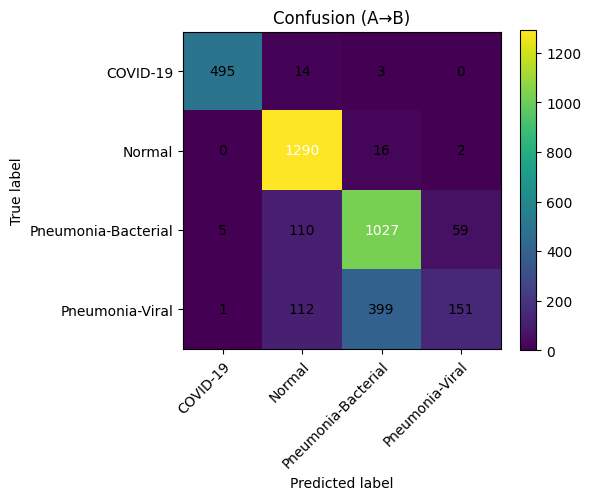

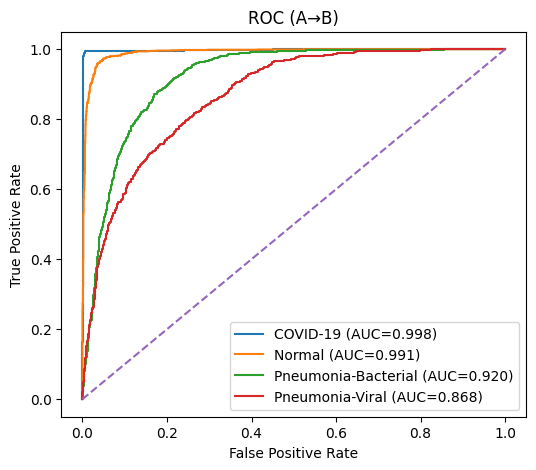


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.99      0.97      0.98       512
             Normal       0.85      0.99      0.91      1308
Pneumonia-Bacterial       0.71      0.86      0.78      1201
    Pneumonia-Viral       0.71      0.23      0.35       663

           accuracy                           0.80      3684
          macro avg       0.81      0.76      0.75      3684
       weighted avg       0.80      0.80      0.77      3684


===== B→A: Train on 3684, Test on 5524 =====


Epoch 1: train loss 0.8331
  Train | Acc: 0.6759 | P: 0.6835 | R: 0.6137 | F1: 0.6086 | AUC(macro): 0.8641 | AUC(micro): 0.8902
Epoch 2: train loss 0.5745
  Train | Acc: 0.7761 | P: 0.7648 | R: 0.7403 | F1: 0.7397 | AUC(macro): 0.9218 | AUC(micro): 0.9460
Epoch 3: train loss 0.5130
  Train | Acc: 0.7959 | P: 0.7842 | R: 0.7663 | F1: 0.7662 | AUC(macro): 0.9316 | AUC(micro): 0.9547
Epoch 4: train loss 0.4945
  Train | Acc: 0.8005 | P: 0.7866 | R: 0.7714 | F1: 0.7711 | AUC(macro): 0.9344 | AUC(micro): 0.9570
Epoch 5: train loss 0.4627
  Train | Acc: 0.8122 | P: 0.8008 | R: 0.7845 | F1: 0.7854 | AUC(macro): 0.9401 | AUC(micro): 0.9620
External Test | Acc: 0.8269 | P: 0.8240 | R: 0.8018 | F1: 0.8091 | AUC(macro): 0.9466 | AUC(micro): 0.9638


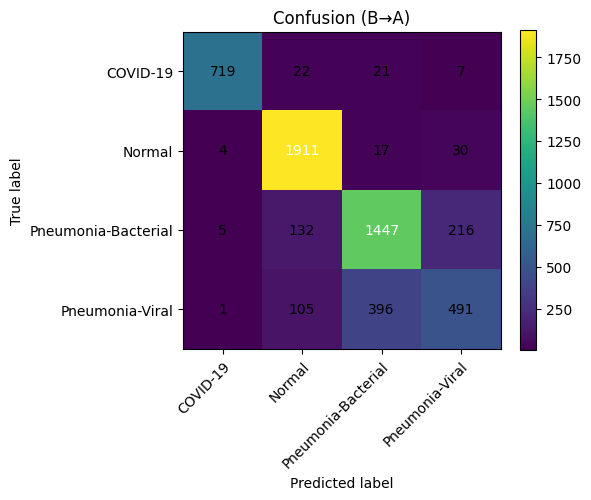

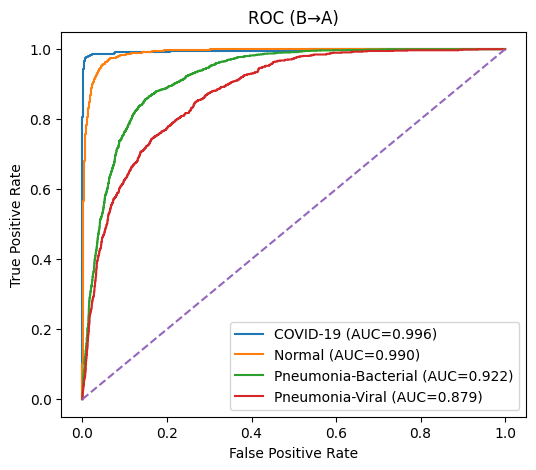


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.99      0.93      0.96       769
             Normal       0.88      0.97      0.92      1962
Pneumonia-Bacterial       0.77      0.80      0.79      1800
    Pneumonia-Viral       0.66      0.49      0.57       993

           accuracy                           0.83      5524
          macro avg       0.82      0.80      0.81      5524
       weighted avg       0.82      0.83      0.82      5524



In [ ]:
 
# Step 8 — External Generalization:
#          Train on ALL of A, evaluate on B (external), then swap (B→A)
 
def train_full_and_eval(train_df, test_df, model_cls=HybridModel,
                        epochs=3, title="A->B"):
    print(f"\n===== {title}: Train on {len(train_df)}, Test on {len(test_df)} =====")
    train_loader = make_loader(train_df, train_tfms, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = make_loader(test_df,  eval_tfms,   batch_size=BATCH_SIZE, shuffle=False)

    model = model_cls(num_classes=NUM_CLASSES).to(DEVICE)
    optim = get_optimizer(model, lr=1e-4)

    for ep in range(1, epochs+1):
        tr_loss, tr_y, tr_pred, tr_prob = run_epoch(model, train_loader, optimizer=optim)
        tr_m = compute_metrics(tr_y, tr_pred, tr_prob, NUM_CLASSES)
        print(f"Epoch {ep}: train loss {tr_loss:.4f}")
        print_metrics("  Train", tr_m)

    # External test
    te_loss, te_y, te_pred, te_prob = run_epoch(model, test_loader, optimizer=None)
    te_m = compute_metrics(te_y, te_pred, te_prob, NUM_CLASSES)
    print_metrics("External Test", te_m)
    plot_confusion(te_y, te_pred, CLASS_NAMES, title=f"Confusion ({title})")
    plot_roc_curves(te_y, te_prob, CLASS_NAMES, title=f"ROC ({title})")

    print("\nPer-class report:")
    print(classification_report(te_y, te_pred, target_names=CLASS_NAMES, zero_division=0))
    return model, (te_y, te_pred, te_prob), te_m

EPOCHS_FULL = 5  # light; increase if you can

# Train on A, test on B
model_A2B, (y_B, pred_B, prob_B), m_A2B = train_full_and_eval(A_df, B_df, HybridModel, EPOCHS_FULL, "A→B")

# Train on B, test on A (swap)
model_B2A, (y_A, pred_A, prob_A), m_B2A = train_full_and_eval(B_df, A_df, HybridModel, EPOCHS_FULL, "B→A")



===== CNN-only A→B: Train on 5524, Test on 3684 =====
Epoch 1: train loss 1.1945
  Train | Acc: 0.4996 | P: 0.4362 | R: 0.3793 | F1: 0.3398 | AUC(macro): 0.6861 | AUC(micro): 0.7354
Epoch 2: train loss 0.9390
  Train | Acc: 0.6490 | P: 0.6405 | R: 0.5540 | F1: 0.5429 | AUC(macro): 0.8439 | AUC(micro): 0.8677
Epoch 3: train loss 0.8249
  Train | Acc: 0.7018 | P: 0.7081 | R: 0.6351 | F1: 0.6292 | AUC(macro): 0.8801 | AUC(micro): 0.9018
Epoch 4: train loss 0.7528
  Train | Acc: 0.7270 | P: 0.7297 | R: 0.6730 | F1: 0.6731 | AUC(macro): 0.8972 | AUC(micro): 0.9175
Epoch 5: train loss 0.7118
  Train | Acc: 0.7411 | P: 0.7423 | R: 0.6940 | F1: 0.6950 | AUC(macro): 0.9046 | AUC(micro): 0.9247
External Test | Acc: 0.7416 | P: 0.7647 | R: 0.6801 | F1: 0.6959 | AUC(macro): 0.9149 | AUC(micro): 0.9264


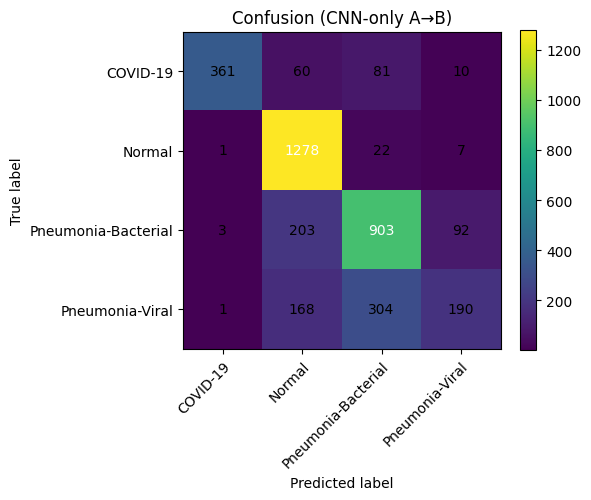

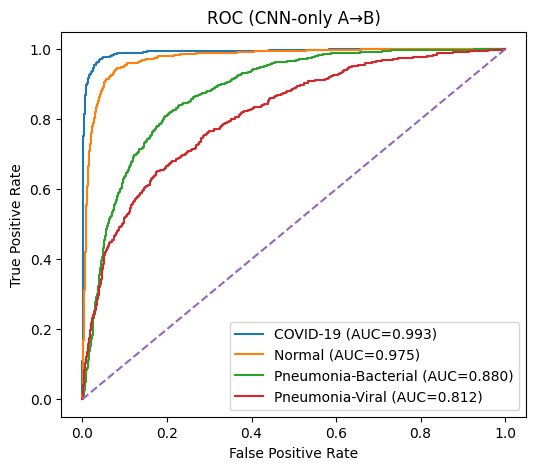


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.99      0.71      0.82       512
             Normal       0.75      0.98      0.85      1308
Pneumonia-Bacterial       0.69      0.75      0.72      1201
    Pneumonia-Viral       0.64      0.29      0.40       663

           accuracy                           0.74      3684
          macro avg       0.76      0.68      0.70      3684
       weighted avg       0.74      0.74      0.72      3684


===== ViT-only A→B: Train on 5524, Test on 3684 =====


Epoch 1: train loss 1.1798
  Train | Acc: 0.4817 | P: 0.4360 | R: 0.3828 | F1: 0.3561 | AUC(macro): 0.7402 | AUC(micro): 0.7512
Epoch 2: train loss 0.9101
  Train | Acc: 0.7075 | P: 0.7136 | R: 0.6292 | F1: 0.6015 | AUC(macro): 0.8882 | AUC(micro): 0.8916
Epoch 3: train loss 0.7892
  Train | Acc: 0.7395 | P: 0.7466 | R: 0.6756 | F1: 0.6552 | AUC(macro): 0.9050 | AUC(micro): 0.9197
Epoch 4: train loss 0.7163
  Train | Acc: 0.7527 | P: 0.7571 | R: 0.6962 | F1: 0.6839 | AUC(macro): 0.9151 | AUC(micro): 0.9320
Epoch 5: train loss 0.6638
  Train | Acc: 0.7759 | P: 0.7795 | R: 0.7291 | F1: 0.7272 | AUC(macro): 0.9234 | AUC(micro): 0.9415
External Test | Acc: 0.7630 | P: 0.7839 | R: 0.7035 | F1: 0.6967 | AUC(macro): 0.9243 | AUC(micro): 0.9363


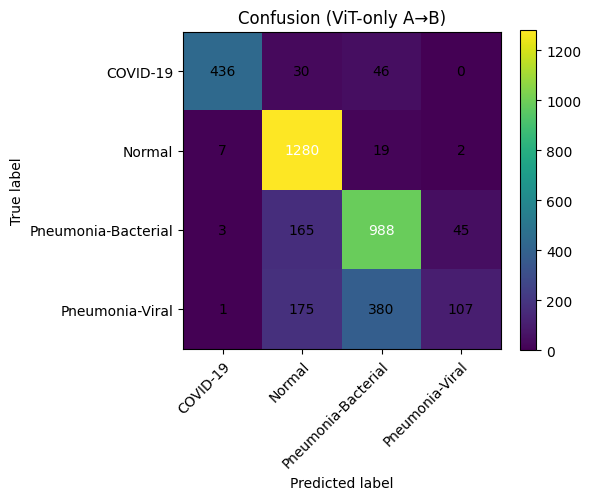

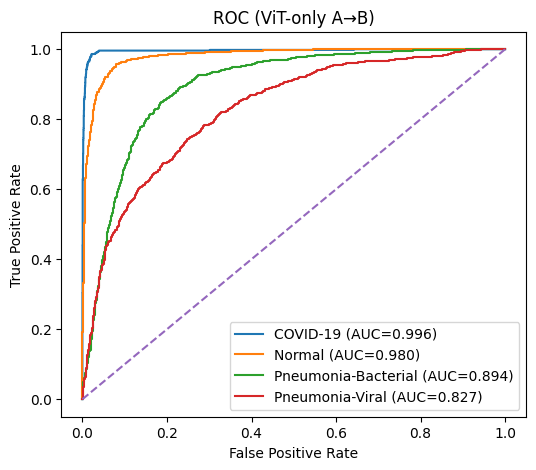


Per-class report:
                     precision    recall  f1-score   support

           COVID-19       0.98      0.85      0.91       512
             Normal       0.78      0.98      0.87      1308
Pneumonia-Bacterial       0.69      0.82      0.75      1201
    Pneumonia-Viral       0.69      0.16      0.26       663

           accuracy                           0.76      3684
          macro avg       0.78      0.70      0.70      3684
       weighted avg       0.76      0.76      0.73      3684


=== Summary: External Test (A→B) ===
Hybrid | Acc: 0.8043 | P: 0.8141 | R: 0.7590 | F1: 0.7523 | AUC(macro): 0.9443 | AUC(micro): 0.9594
CNN-only | Acc: 0.7416 | P: 0.7647 | R: 0.6801 | F1: 0.6959 | AUC(macro): 0.9149 | AUC(micro): 0.9264
ViT-only | Acc: 0.7630 | P: 0.7839 | R: 0.7035 | F1: 0.6967 | AUC(macro): 0.9243 | AUC(micro): 0.9363


In [ ]:
 
# Step 9 — Baselines: CNN-only and ViT-only (train on A, test on B)
#          (to show hybrid improvement)
 
cnn_model, (_, _, _), m_cnn = train_full_and_eval(A_df, B_df, CNNOnly,  epochs=EPOCHS_FULL, title="CNN-only A→B")
vit_model, (_, _, _), m_vit = train_full_and_eval(A_df, B_df, ViTOnly,  epochs=EPOCHS_FULL, title="ViT-only A→B")

print("\n=== Summary: External Test (A→B) ===")
for name, m in [("Hybrid", m_A2B), ("CNN-only", m_cnn), ("ViT-only", m_vit)]:
    print_metrics(name, m)


In [ ]:
 
# Step 10 — Grad-CAM (CNN branch) for interpretability
#           We visualize top-1 prediction attention on ResNet layer4.
 
def gradcam_resnet18(model_hybrid, img_tensor, target_class=None):
    """
    img_tensor: [1, 3, 224, 224] (already normalized)
    Returns heatmap (H, W) in [0,1]
    """
    model_hybrid.eval()
    cnn = model_hybrid.cnn  # ResNet18 backbone
    # Hook to capture activations & gradients from layer4
    conv_layer = cnn.layer4

    activations = []
    gradients = []

    def fwd_hook(module, inp, out):
        activations.append(out.detach())
    def bwd_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    h1 = conv_layer.register_forward_hook(fwd_hook)
    h2 = conv_layer.register_backward_hook(bwd_hook)

    # Forward pass through full hybrid (so classifier decides target)
    img_tensor = img_tensor.to(DEVICE)
    logits = model_hybrid(img_tensor)
    if target_class is None:
        target_class = logits.argmax(dim=1)

    loss = logits[:, target_class].sum()
    model_hybrid.zero_grad()
    loss.backward()

    # Compute Grad-CAM on captured maps
    fmap = activations[0]         # [B, C, H, W]
    grads = gradients[0]          # [B, C, H, W]
    weights = grads.mean(dim=(2,3), keepdim=True)  # [B, C, 1, 1]
    cam = (weights * fmap).sum(dim=1, keepdim=True)  # [B, 1, H, W]
    cam = F.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    heatmap = cam[0,0].detach().cpu().numpy()

    # Cleanup hooks
    h1.remove(); h2.remove()
    return heatmap, int(target_class.item())

def show_gradcam_on_image(img_path, heatmap, alpha=0.35):
    # Show overlay using PIL/matplotlib
    img = Image.open(img_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    heat = Image.fromarray(np.uint8(255*heatmap)).resize(img.size, resample=Image.BILINEAR)
    heat = np.array(heat)
    fig = plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img); plt.axis('off'); plt.title("Original")
    plt.subplot(1,2,2);
    plt.imshow(img); plt.imshow(heat, cmap='jet', alpha=alpha);
    plt.axis('off'); plt.title("Grad-CAM")
    plt.show()

# Pick a few external test images from B to visualize
sample_df = B_df.sample(3, random_state=SEED).reset_index(drop=True)
gc_model = model_A2B  # trained on A
gc_model.eval()

for i in range(len(sample_df)):
    p = sample_df.loc[i, "path"]
    # Prepare tensor with eval transforms
    img = Image.open(p).convert("RGB")
    x = eval_tfms(img).unsqueeze(0)  # [1,3,224,224]
    heatmap, pred_cls = gradcam_resnet18(gc_model, x, target_class=None)
    print(f"Image: {Path(p).name} | Pred: {idx2label[pred_cls]}")
    show_gradcam_on_image(p, heatmap)


In [14]:
def compare_models_on_external(test_df, models_dict, batch_size=16):
    """
    models_dict: dict of {name: model_instance}
    test_df: DataFrame with 'path' and 'y' columns
    """
    results = {}
    test_loader = make_loader(test_df, eval_tfms, batch_size=batch_size, shuffle=False)

    for name, model in models_dict.items():
        model.eval()
        _, y_true, y_pred, y_prob = run_epoch(model, test_loader, optimizer=None)
        metrics = compute_metrics(y_true, y_pred, y_prob, NUM_CLASSES)
        results[name] = metrics
        print(f"\n--- {name} ---")
        print_metrics("External Test", metrics)

    return results


In [15]:
models_to_compare = {
    "Hybrid": model_A2B,
    "CNN-only": cnn_model,
    "ViT-only": vit_model
}

results = compare_models_on_external(B_df, models_to_compare)



--- Hybrid ---
External Test | Acc: 0.8043 | P: 0.8141 | R: 0.7590 | F1: 0.7523 | AUC(macro): 0.9443 | AUC(micro): 0.9594

--- CNN-only ---
External Test | Acc: 0.7416 | P: 0.7647 | R: 0.6801 | F1: 0.6959 | AUC(macro): 0.9149 | AUC(micro): 0.9264

--- ViT-only ---
External Test | Acc: 0.7630 | P: 0.7839 | R: 0.7035 | F1: 0.6967 | AUC(macro): 0.9243 | AUC(micro): 0.9363


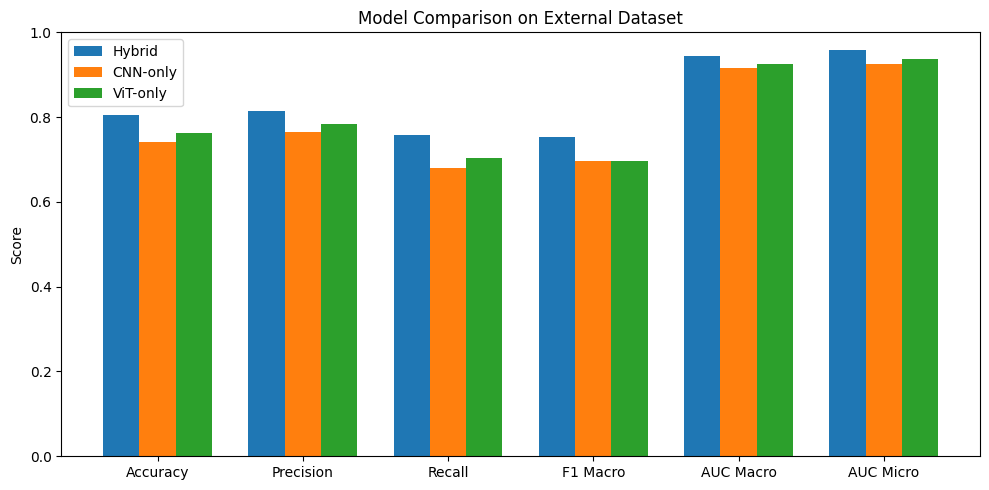

In [16]:
import matplotlib.pyplot as plt
import numpy as np

metrics_to_plot = ["acc", "prec", "rec", "f1", "auc_macro", "auc_micro"]
metric_labels = ["Accuracy", "Precision", "Recall", "F1 Macro", "AUC Macro", "AUC Micro"]

models = list(results.keys())
num_metrics = len(metrics_to_plot)
num_models = len(models)

# Prepare data
data = np.array([[results[m][metric] for metric in metrics_to_plot] for m in models])  # shape: (3,6)

x = np.arange(num_metrics)  # one position per metric
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10,5))

# Plot each model
for i, model_name in enumerate(models):
    ax.bar(x + i*width - width, data[i], width, label=model_name)

ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Comparison on External Dataset")
ax.legend()
plt.tight_layout()
plt.show()
